In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install librosa

# Setup tensorboard

In [3]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-04-21 01:29:30--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.73.94.166, 52.2.175.150, 34.206.36.121, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.73.94.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14977695 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  14.28M  43.5MB/s    in 0.3s    

2019-04-21 01:29:31 (43.5 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [14977695/14977695]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [6]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://bea33ade.ngrok.io


# Imports

In [0]:
import librosa
import pickle
import math

In [0]:
import numpy as np
import tensorflow as tf

# Read and transform data

Convert raw byte stream into useful feature space. STFT on the signals serves the initial feature extraction process

In [0]:
base_path = './drive/My Drive/Colab Notebooks/hw4/speaker-verification/'
train_path = base_path + 'hw4_trs.pkl'
test_path = base_path + 'hw4_tes.pkl'

base_path_model = base_path + 'model/'

In [0]:
with open(train_path, 'rb') as f:
  train_raw = pickle.load(f)

with open(test_path, 'rb') as f:
  test_raw = pickle.load(f)

trs.pkl contains an 500×16,180 matrix, whose row is a speech signal with 16,180 samples. They are
the returned vectors from the librosa.load function. Similarly, tes.pkl holds a 200×22,631 matrix

In [11]:
train_raw.shape, test_raw.shape

((500, 16180), (200, 22631))

## Convert into audio (.wav file) for checking manually

In [0]:
# for i in range(train_raw.shape[0]):
#   librosa.output.write_wav(base_path + 'trs/trs' + ('0000' + str(i))[-4:] + '.wav', train_raw[i], 16000)

In [0]:
# for i in range(test_raw.shape[0]):
#   librosa.output.write_wav(base_path + 'tes/tes' + ('0000' + str(i))[-4:] + '.wav', test_raw[i], 16000)

## Extract features using STFT

In [0]:
train_complex = np.array([librosa.stft(x, n_fft=1024, hop_length=512).T for x in train_raw])
test_complex = np.array([librosa.stft(x, n_fft=1024, hop_length=512).T for x in test_raw])

In [0]:
train = np.abs(train_complex)
test = np.abs(test_complex)

In [0]:
# a = [[1, 2], [3, 4]]
# np.pad()

In [17]:
train.shape, test.shape

((500, 32, 513), (200, 45, 513))

# Generate mini-batches

## Structure of training data

The training matrix is ordered by speakers. Each speaker has 10 utterances, and there are 50 such
speakers (that’s why there are 500 rows). Similarly, the test set has 20 speakers, each of which is with
10 utterances.

In [0]:
samples_per_class = 10

## Procedure to generate mini-batches

1. Randomly sample L pairs of utterances from the ten utterance of the first speaker. In theory, there are $10 \choose 2$= 45 pairs you can sample from. You can use all 45 of them if you want. These are the positive examples in your first minibatch

2. Randomly sample L utterances from the 49 training speakers. Using them and the ten utterances of
the first speaker, form another set of L pairs. If L > 10, you’ll need to repeatedly use the first speaker’s
utterance (i.e. sampling with replacement). This set is your negative examples, each of whose pair
contains an utterance from the first speaker and a random utterance spoken by a different speaker.

3. In this first minibatch, you have 2L pairs of utterances.

4. Repeat this process for the other training speakers, so that each speaker is represented by L positive
pairs and L negative pairs. By doing so, you can form 50 minibatches with a balanced number of
positive and negative pair

In [0]:
max_length = 50
num_features = 513

In [0]:
def pad_zeros(stft):
  stft_val = np.zeros((max_length, num_features))
  stft_val[:stft.shape[0], :stft.shape[1]] = stft
  return stft_val

In [0]:
'''
data: train/test
batch_size: return batch_size number of positive and another batch_size number of negative pairs
stick: if true, one training class will be common across positive and negative pairs

returns:
x: list of pairs
y: 1 for positive pairs, 0 for negative
'''
def next_batch(data, batch_size, stick=False):
  x1, x2, y, l = [], [], [], []
  
  num_classes = len(data) // samples_per_class
  base = np.random.randint(num_classes)
  
  # generate positive pairs
  for _ in range(batch_size):
    # randomly select idx_0 only if stick is false
    if not stick:
      base = np.random.randint(num_classes)
      
    idx_0, idx_1 = base * samples_per_class + np.random.choice(np.arange(samples_per_class), size=2, replace=False)
    x1.append(pad_zeros(data[idx_0]))
    x2.append(pad_zeros(data[idx_1]))
    
    l.append(data[idx_0].shape[0])
    y.append([1])
    
  # generate negative pairs
  for _ in range(batch_size):
    # randomly select idx_0 only if stick is false
    if not stick:
      base = np.random.randint(num_classes)
    
    # make sure neg_base is not same as base
    while True:
      neg_base = np.random.randint(num_classes)
      if neg_base != base:
        break
      
    idx_0 = base * samples_per_class + np.random.randint(samples_per_class)
    idx_1 = neg_base * samples_per_class + np.random.randint(samples_per_class)
        
    x1.append(pad_zeros(train[idx_0]))
    x2.append(pad_zeros(train[idx_1]))
    
    l.append(train[idx_0].shape[0])
    y.append([0])
    
  return np.array(x1), np.array(x2), np.array(y), np.array(l)

# Create model

In [0]:
num_hidden_rnn = [500, 400]
learning_rate = 0.0001

In [0]:
# Using this implementation as reference https://github.com/ardiya/siamesenetwork-tensorflow/blob/master/train.py

def model(inp, seq_len):
  cells = []
  
  for i, units in enumerate(num_hidden_rnn):
    cell_name = 'gru_' + str(i)
    cell = tf.nn.rnn_cell.DropoutWrapper(tf.nn.rnn_cell.GRUCell(units, reuse=tf.AUTO_REUSE, name=cell_name, kernel_initializer=tf.contrib.layers.variance_scaling_initializer(), activation='relu'))
    cells.append(cell)
  
  rnn = tf.nn.rnn_cell.MultiRNNCell(cells)

  output, state = tf.nn.dynamic_rnn(rnn, inp, dtype=tf.float32, sequence_length=seq_len)
      
  flattened_1 = tf.contrib.layers.flatten(output)
  dense_1 = tf.layers.dense(inputs=flattened_1, activation='relu', name='dense_1', reuse=tf.AUTO_REUSE, units=200, kernel_initializer=tf.contrib.layers.variance_scaling_initializer())
  dense_2 = tf.layers.dense(inputs=dense_1, activation='relu', name='dense_2', reuse=tf.AUTO_REUSE, units=20, kernel_initializer=tf.contrib.layers.variance_scaling_initializer())
    
  return dense_2

## Loss function

In [0]:
def contrastive_loss(model1, model2, y):
  # y can take values in {0, 1}
  
  dotProduct = tf.reduce_sum(tf.multiply(model1, model2), axis = 1)
  dotProduct = tf.reshape(dotProduct, [-1, 1])
  loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=dotProduct))
  
  return loss

## Inputs to the model

In [0]:
X1 = tf.placeholder(dtype=tf.float32, shape=[None, max_length, num_features])
X2 = tf.placeholder(dtype=tf.float32, shape=[None, max_length, num_features])
y = tf.placeholder(dtype=tf.float32, shape=[None, 1])
seq_len = tf.placeholder(dtype=tf.int32, shape=None)

## Plug everything together

In [26]:
model1 = model(X1, seq_len)
model2 = model(X2, seq_len)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.


In [0]:
loss = contrastive_loss(model1, model2, y)
# loss = tf.contrib.losses.metric_learning.contrastive_loss(
#     y,
#     model1,
#     model2,
#     margin=10.0
# )

In [0]:
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss=loss)

# Train model

In [0]:
batch_size = 100
num_epochs = 1000
display_step = 100
save_step = 50

num_samples_tr = train.shape[0]
num_samples_te = test.shape[0]
num_batches_tr = int(math.ceil(num_samples_tr/batch_size))
num_batches_te = int(math.ceil(num_samples_te/batch_size))

train_loss = []
test_loss = []

In [0]:
sess = tf.Session()
saver = tf.train.Saver()

In [31]:
# for contrastive loss

sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter(LOG_DIR, sess.graph)
writer.close()

num_batches_tr = num_samples_tr // batch_size
for epoch in range(1, num_epochs + 1):
  loss_val = 0
  for i in range(num_batches_tr):
    batch_x1, batch_x2, batch_y, l = next_batch(train, batch_size)
    
    _, lv = sess.run([train_op, loss], feed_dict={X1: batch_x1, X2: batch_x2, y: batch_y, seq_len: l})
    loss_val += lv
  
  loss_val = loss_val / (num_batches_tr * 2 * batch_size)
  
  if epoch % display_step == 0:
    print(epoch, loss_val)
  if epoch % save_step == 0:
    saver.save(sess, base_path_model + 'model_' + str(epoch) + '.ckpt')

100 0.5622415313720703
200 0.5254189147949219
300 0.5125822143554688
Instructions for updating:
Use standard file APIs to delete files with this prefix.
400 0.5034067993164062
500 0.47776305389404294
600 0.4933585510253906
700 0.5054808044433594
800 0.4645534133911133
900 0.4870986099243164
1000 0.478406379699707


# Test model

In [0]:
def predict(model1, model2):
  dotProduct = tf.reduce_sum(tf.math.multiply(model1, model2), axis = 1)
  dotProduct = tf.reshape(dotProduct, [-1, 1])
  prediction = tf.cast(tf.greater(dotProduct, 0), tf.int32)
  return dotProduct, prediction

In [0]:
dp, prediction = predict(model1, model2)

## Training data

In [0]:
correct, total = 0, 0
for i in range(num_batches_tr):
  batch_x1, batch_x2, batch_y, l = next_batch(train, batch_size)
  
  dpr, pred = sess.run([dp, prediction], feed_dict={X1: batch_x1, X2: batch_x2, seq_len: l})
  correct += np.sum(pred == batch_y)
  total += batch_x1.shape[0]

In [35]:
print('Training accuracy:', correct / total * 100)

Training accuracy: 90.5


## Testing data

In [0]:
num_batches_te = num_samples_te // batch_size

correct, total = 0, 0
for i in range(num_batches_te):
  batch_x1, batch_x2, batch_y, l = next_batch(test, batch_size)

  pred = sess.run([prediction], feed_dict={X1: batch_x1, X2: batch_x2, seq_len: l})
  correct += np.sum(pred == batch_y)
  
  total += batch_x1.shape[0]

In [37]:
print('Testing accuracyL', correct / total * 100)

Testing accuracyL 87.75


# Visualize embeddings in reduced dimensions (Principal Components)


In [0]:
padded_tr = np.array([pad_zeros(tr) for tr in train])
tr_seq_len = np.array([tr.shape[0] for tr in train])

In [0]:
embeddings = sess.run(model1, feed_dict={X1: padded_tr, seq_len: tr_seq_len})
target = np.array([x//10 for x in np.arange(embeddings.shape[0])])

In [0]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [0]:
def plot_tsne(ax, x, y, title):
  model = TSNE(learning_rate=100)
  transformed = model.fit_transform(x)
  tx = transformed[:, 0]
  ty = transformed[:, 1]
  ax.scatter(tx, ty, c=y, cmap='plasma', s=20)
  ax.set_title(title)
  for d in range(50):
    cx, cy = np.mean(transformed[y == d], axis=0)
    plt.text(cx, cy, str(d), fontsize=15, color='k', weight='bold')

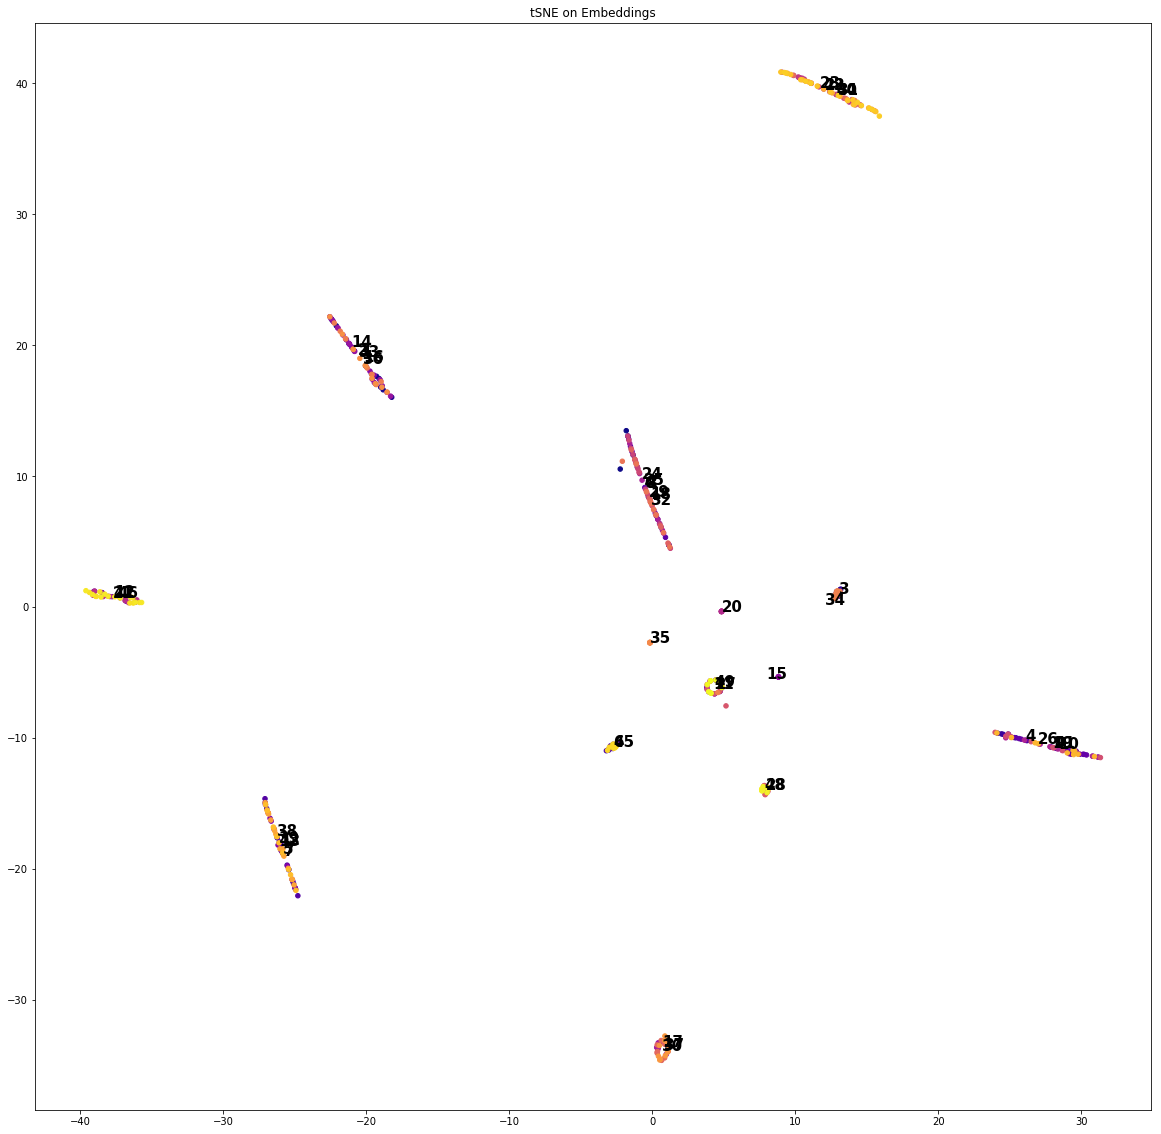

In [42]:
plt.figure(figsize=(20, 20))
plot_tsne(plt.gca(), embeddings, target, 'tSNE on Embeddings')